In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import os
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'w'
import seaborn as sns

In [17]:
class HierarchicalNormalSimulator:
    
    def __init__(self):    
        pass
    
    def draw_from_prior(self, model_index, n_clusters, mu0, tau20, sigma_t, sigma_s):
        """
        Draws parameter values from the specified prior distributions of the 
        hyperprior and the conditional prior.
        ----------
        
        Arguments:
        model_index : int -- index of the model to be simulated from
        n_clusters  : int -- number of higher order clusters that the observations are nested in
        mu0         : float -- higher order mean prior - mean
        tau20       : float -- higher order mean prior - variance
        sigma_t     : float -- higher order variance prior
        sigma_s     : float -- variance prior
        """
        
        if model_index == 0: 
            mu = 0
        if model_index == 1:
            mu = np.random.normal(loc=mu0, scale=np.sqrt(tau20))
            
        tau2 = stats.halfnorm.rvs(scale=sigma_t)
        sigma2 = stats.halfnorm.rvs(scale=sigma_s)
        theta = np.random.normal(loc=mu, scale=np.sqrt(tau2), size=n_clusters)
        return theta, sigma2
    
    def gen_from_likelihood(self, theta, sigma2, n_obs):
        """
        Generates a single hierarchical dataset from the sampled parameter values.
        ----------
        
        Arguments: 
        params : list -- parameters sampled from prior 
        n_obs  : int -- number of observations per cluster
        """
        
        X = np.random.normal(loc=theta, scale=sigma2, size=(n_obs, theta.shape[0])).T 
        return X
    
    def generate_single(self, model_index, n_clusters, n_obs, mu0=0, tau20=1, sigma_t=1, sigma_s=1):
        """
        Generates a single hierarchical dataset utilizing the draw_from_prior and gen_from_likelihood functions.
        ----------
        
        Arguments:
        model_index : int -- index of the model to be simulated from
        n_clusters  : int -- number of higher order clusters that the observations are nested in
        n_obs       : int -- number of observations per cluster
        mu0         : float -- higher order mean prior - mean
        tau20       : float -- higher order mean prior - variance
        sigma_t     : float -- higher order variance prior
        sigma_s     : float -- variance prior
        --------
        
        Returns:
        numpy array of shape (n_clusters, n_obs, n_variables) - contains the simulated hierarchical datasets
        """
        theta, sigma2 = self.draw_from_prior(model_index, n_clusters, mu0, tau20, sigma_t, sigma_s)
        x_generated = self.gen_from_likelihood(theta, sigma2, n_obs)
        return x_generated[...,np.newaxis]
        
    def simulate(self, batch_size, n_models, n_clusters, n_obs, mu0=0, tau20=1, sigma_t=1, sigma_s=1):
        """
        Simulates multiple hierarchical datasets. Useful for single usage and debugging (both without the MainSimulator).
        ----------
        
        Arguments:
        batch_size  : int -- number of batches to be generated
        n_models    : int -- number of models to be simulated from
        n_clusters  : int -- number of higher order clusters that the observations are nested in
        n_obs       : int -- number of observations per cluster
        n_variables : int -- number of variables in the simulated datasets 
        mu0         : float -- higher order mean prior - mean
        tau20       : float -- higher order mean prior - variance
        sigma_t     : float -- higher order variance prior
        sigma_s     : float -- variance prior
        --------
        
        Returns:
        numpy array of shape (batch_size * n_models, n_clusters, n_obs, n_variables) - contains the simulated hierarchical datasets
        """
        
        X = []
        for b in range(batch_size):
            prior_sample = self.draw_from_prior(n_clusters, mu0, tau20, sigma_t, sigma_s)
            x_generated = self.gen_from_likelihood(prior_sample, n_obs)
            X.append(x_generated)
        return np.array(X)[...,np.newaxis]

## Version that saves true parameter values (to check Stan code)

In [18]:
class HierarchicalNormalSimulator:
    
    def __init__(self):    
        pass
    
    def draw_from_prior(self, model_index, n_clusters, mu0, tau20, sigma_t, sigma_s):
        """
        Draws parameter values from the specified prior distributions of the 
        hyperprior and the conditional prior.
        ----------
        
        Arguments:
        model_index : int -- index of the model to be simulated from
        n_clusters  : int -- number of higher order clusters that the observations are nested in
        mu0         : float -- higher order mean prior - mean
        tau20       : float -- higher order mean prior - variance
        sigma_t     : float -- higher order variance prior
        sigma_s     : float -- variance prior
        """
        
        if model_index == 0: 
            mu = 0
        if model_index == 1:
            mu = np.random.normal(loc=mu0, scale=np.sqrt(tau20))
            
        tau2 = stats.halfnorm.rvs(scale=sigma_t)
        sigma2 = stats.halfnorm.rvs(scale=sigma_s)
        theta = np.random.normal(loc=mu, scale=np.sqrt(tau2), size=n_clusters)
        return theta, sigma2, mu, tau2
    
    def gen_from_likelihood(self, theta, sigma2, n_obs):
        """
        Generates a single hierarchical dataset from the sampled parameter values.
        ----------
        
        Arguments: 
        params : list -- parameters sampled from prior 
        n_obs  : int -- number of observations per cluster
        """
        
        X = np.random.normal(loc=theta, scale=sigma2, size=(n_obs, theta.shape[0])).T 
        return X
    
    def generate_single(self, model_index, n_clusters, n_obs, mu0=0, tau20=1, sigma_t=1, sigma_s=1):
        """
        Generates a single hierarchical dataset utilizing the draw_from_prior and gen_from_likelihood functions.
        ----------
        
        Arguments:
        model_index : int -- index of the model to be simulated from
        n_clusters  : int -- number of higher order clusters that the observations are nested in
        n_obs       : int -- number of observations per cluster
        mu0         : float -- higher order mean prior - mean
        tau20       : float -- higher order mean prior - variance
        sigma_t     : float -- higher order variance prior
        sigma_s     : float -- variance prior
        --------
        
        Returns:
        numpy array of shape (n_clusters, n_obs, n_variables) - contains the simulated hierarchical datasets
        """
        theta, sigma2, mu, tau2 = self.draw_from_prior(model_index, n_clusters, mu0, tau20, sigma_t, sigma_s)
        x_generated = self.gen_from_likelihood(theta, sigma2, n_obs)
        return x_generated[...,np.newaxis], sigma2, mu, tau2
        
    def simulate(self, batch_size, n_models, n_clusters, n_obs, mu0=0, tau20=1, sigma_t=1, sigma_s=1):
        """
        Simulates multiple hierarchical datasets. Useful for single usage and debugging (both without the MainSimulator).
        ----------
        
        Arguments:
        batch_size  : int -- number of batches to be generated
        n_models    : int -- number of models to be simulated from
        n_clusters  : int -- number of higher order clusters that the observations are nested in
        n_obs       : int -- number of observations per cluster
        n_variables : int -- number of variables in the simulated datasets 
        mu0         : float -- higher order mean prior - mean
        tau20       : float -- higher order mean prior - variance
        sigma_t     : float -- higher order variance prior
        sigma_s     : float -- variance prior
        --------
        
        Returns:
        numpy array of shape (batch_size * n_models, n_clusters, n_obs, n_variables) - contains the simulated hierarchical datasets
        """
        
        X = []
        for b in range(batch_size):
            prior_sample = self.draw_from_prior(n_clusters, mu0, tau20, sigma_t, sigma_s)
            x_generated = self.gen_from_likelihood(prior_sample, n_obs)
            X.append(x_generated)
        return np.array(X)[...,np.newaxis], params

In [19]:
class MainSimulator:
    
    def __init__(self, simulator):
        
        self.simulator = simulator
    
    def draw_from_model_prior(self, batch_size, n_models, model_prior):
        """
        Creates the sequence of models to be simulated from in the batch.
        ----------
        
        Arguments:
        batch_size     : int -- number of batches to be generated
        n_models       : int -- number of models to be simulated from
        model_prior    : list -- prior model probabilities
        --------
        
        Returns:
        array of shape (batch_size) - array of indices corresponding to the sampled model from p(M).
        """
        
        # create base list of model indices
        model_base_indices = [*range(n_models)]
        
        # uniform prior over model probabilities if no model prior given
        if model_prior == None:
            model_prior = [1/n_models] * n_models
        
        # generate sampling list of model indeces
        model_indices = np.random.choice(model_base_indices, size=batch_size, p=model_prior)
        return model_indices
    
    def simulate(self, batch_size, n_models, model_prior, 
                 n_clust_min=2, n_clust_max=100, n_obs_min=2, n_obs_max=200):
        """
        Simulates a batch of hierarchical datasets.
        ----------
        
        Arguments:
        batch_size     : int -- number of datasets to be generated per batch
        n_models       : int -- number of models to be simulated from
        model_prior    : list -- prior model probabilities
        n_clust_min    : int -- minimum number of clusters
        n_clust_max    : int -- maximum number of cluster
        n_obs_min      : int -- minimum number of observations
        n_obs_max      : int -- maximum number of observations
        --------
        
        Returns:
        dict of {'X' : array of shape (batch_size, n_clusters, n_obs, n_variables),  
                 'm' : array of shape (batch_size)}
        """
        # Draw K and N (drawn values apply for all datasets in the batch)
        n_clusters = np.random.randint(n_clust_min, n_clust_max+1)
        n_obs = np.random.randint(n_obs_min, n_obs_max+1)
        
        # Draw sampling list of model indices
        model_indices = self.draw_from_model_prior(batch_size, n_models, model_prior)
        
        # Prepare an array to hold simulations
        X_gen = np.zeros((batch_size, n_clusters, n_obs, 1), dtype=np.float32)
        sigma2 = np.zeros(batch_size, dtype=np.float32)
        mu = np.zeros(batch_size, dtype=np.float32)
        tau2 = np.zeros(batch_size, dtype=np.float32)
        
        for b in range(batch_size):
            single_simulations = self.simulator.generate_single(model_indices[b], n_clusters, n_obs)
            X_gen[b] = single_simulations[0]
            sigma2[b] = single_simulations[1]
            mu[b] = single_simulations[2]
            tau2[b] = single_simulations[3]
               
        return {'X': X_gen, 'm': model_indices, 'n_clusters': n_clusters, 'n_obs': n_obs, 
                'sigma2': sigma2, 'mu': mu, 'tau2':tau2}
    
    def __call__(self, batch_size, n_models=2, model_prior=None, 
                 n_clust_min=2, n_clust_max=100, n_obs_min=2, n_obs_max=200):
        return self.simulate(batch_size, n_models, model_prior, n_clust_min, n_clust_max, n_obs_min, n_obs_max)

In [20]:
np.random.seed(42)

simulator = MainSimulator(HierarchicalNormalSimulator())

test_data_bf = simulator(100, n_clust_min=50, n_clust_max=50, n_obs_min=50, n_obs_max=50)
test_data_bf_true_indices = test_data_bf["m"]

In [21]:
true_params = pd.DataFrame([np.arange(1,101), test_data_bf['sigma2'], test_data_bf['mu'], test_data_bf['tau2']]).T
true_params.columns = ['dataset', 'sigma2', 'mu', 'tau2']

In [22]:
true_params.head(50)

,dataset,sigma2,mu,tau2
0,1.0,0.299007,0.000000,0.087047
1,2.0,0.296576,-0.443044,0.479493
2,3.0,0.367510,-0.446321,0.200639
3,4.0,2.710332,0.117707,1.671761
4,5.0,0.586695,0.000000,0.009227
5,6.0,0.843102,0.000000,0.358300
6,7.0,0.843829,0.000000,0.645184
7,8.0,1.147066,1.346481,1.559742
8,9.0,0.174923,1.139242,0.306452
9,10.0,1.123883,-1.059588,1.023681


In [23]:
true_params.tail(50)

,dataset,sigma2,mu,tau2
50,51.0,0.048346,-1.256439,0.185668
51,52.0,0.308650,0.471611,0.441173
52,53.0,0.608660,0.002538,0.745110
53,54.0,0.614199,1.397682,1.740180
54,55.0,1.834239,-1.932088,0.426684
55,56.0,0.543366,0.797525,1.063504
56,57.0,0.897363,0.000000,0.391738
57,58.0,0.595317,0.000000,1.396765
58,59.0,0.982799,0.000000,1.515246
59,60.0,0.882665,0.000000,0.291977


## Inspect Stan parameter recovery

In [5]:
stan_params = pd.read_csv(os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data', '02_bridge_sampling_comparison', '2022_05_03_BF_BS_params'), sep = " ").reset_index(drop=True)

In [25]:
stan_params

,dataset,true_model,mean.theta.,var.theta.,sigma2,mu,tau2,dataset.1,true_model.1,mean.theta..1,var.theta..1,sigma2.1,mu.1,tau2.1
0,1,0,0.009337,0.073365,0.087379,NaN,0.080137,1,0,0.009553,0.073434,0.087377,0.009559,0.081843
1,2,1,-0.478052,0.407522,0.089856,NaN,0.670125,2,1,-0.479344,0.406333,0.089858,-0.475220,0.439899
2,3,1,-0.423288,0.209047,0.143570,NaN,0.417290,3,1,-0.426325,0.206599,0.143580,-0.424563,0.227612
3,4,1,0.489088,1.499706,6.923972,NaN,1.741987,4,1,0.528085,1.471251,6.923711,0.512100,1.552302
4,5,0,0.001284,0.004409,0.332901,NaN,0.008813,5,0,0.002291,0.004550,0.332982,0.002348,0.009145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,0,0.004441,0.296922,0.483897,NaN,0.324834,96,0,0.004512,0.297385,0.483871,0.004324,0.331923
96,97,1,0.942981,0.521094,0.058055,NaN,1.392113,97,1,0.943767,0.519733,0.058058,0.933413,0.558327
97,98,0,-0.003039,0.062405,0.512049,NaN,0.076272,98,0,-0.003521,0.062704,0.512152,-0.003606,0.078026
98,99,0,-0.152731,1.246218,1.960294,NaN,1.290185,99,0,-0.157436,1.246376,1.960160,-0.153326,1.291059


Text(0.5, 1.0, 'Sigma2')

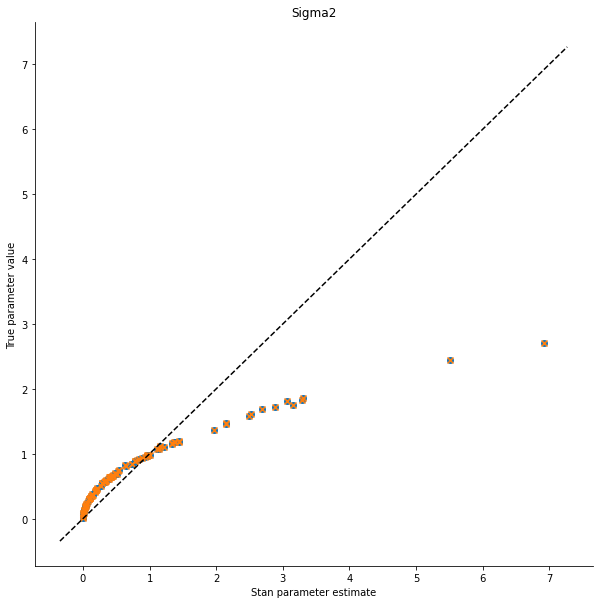

In [26]:
# Sigma2

f, ax = plt.subplots(1, 1, figsize=(10,10))
ax.scatter(stan_params['sigma2'], true_params['sigma2'])
ax.scatter(stan_params['sigma2.1'], true_params['sigma2'], marker="x")
ax.plot(ax.get_xlim(), ax.get_xlim(), '--', color='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Stan parameter estimate')
ax.set_ylabel('True parameter value')
ax.set_title('Sigma2')

Text(0.5, 1.0, '$mu$')

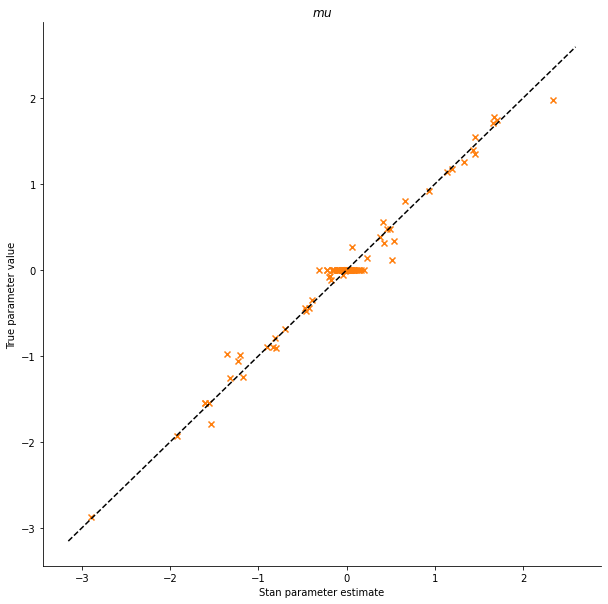

In [27]:
# Mu

f, ax = plt.subplots(1, 1, figsize=(10,10))
ax.scatter(stan_params['mu'], true_params['mu']) # blank, only model1 estimates mu
ax.scatter(stan_params['mu.1'], true_params['mu'], marker="x")
ax.plot(ax.get_xlim(), ax.get_xlim(), '--', color='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Stan parameter estimate')
ax.set_ylabel('True parameter value')
ax.set_title('$mu$')

Text(0.5, 1.0, 'Tau2')

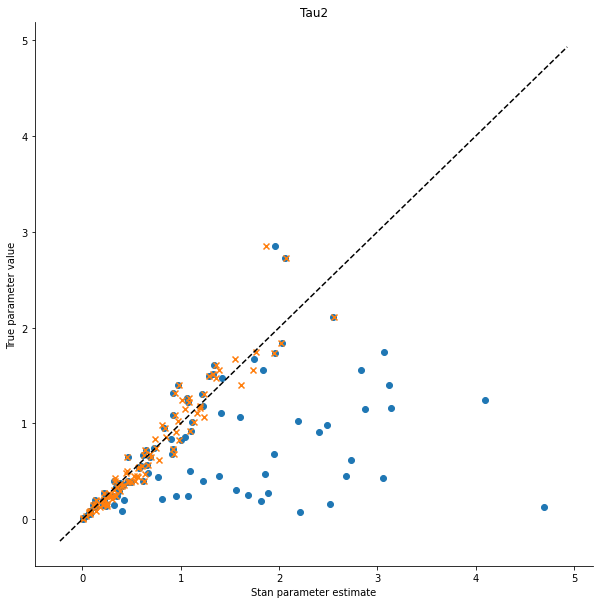

In [28]:
# Tau2

f, ax = plt.subplots(1, 1, figsize=(10,10))
ax.scatter(stan_params['tau2'], true_params['tau2'])
ax.scatter(stan_params['tau2.1'], true_params['tau2'], marker="x")
ax.plot(ax.get_xlim(), ax.get_xlim(), '--', color='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Stan parameter estimate')
ax.set_ylabel('True parameter value')
ax.set_title('Tau2')